In [1]:
%matplotlib inline


분류기(Classifier) 학습하기
============================


데이터는 어떻게 하나요?
------------------------

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용하거나, NLTK나 SpaCy도
   사용

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.


이미지 분류기 학습하기
----------------------------

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)
2. 합성곱 신경망(Convolution Neural Network)을 정의
3. 손실 함수를 정의
4. 학습용 데이터를 사용하여 신경망을 학습
5. 시험용 데이터를 사용하여 신경망을 검사

### CIFAR10을 불러오고 정규화

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


학습용 이미지 몇 개를 보겠습니다.

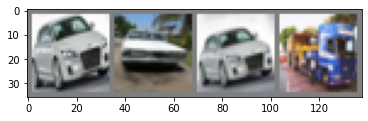

  car   car   car truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[:4]))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 합성곱 신경망(Convolution Neural Network) 정의

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 손실 함수와 Optimizer 정의
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 신경망 학습

In [7]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].cuda(), data[1].cuda()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   200] loss: 0.230
[1,   400] loss: 0.230
[1,   600] loss: 0.230
[1,   800] loss: 0.230
[1,  1000] loss: 0.229
[1,  1200] loss: 0.226
[1,  1400] loss: 0.220
[2,   200] loss: 0.207
[2,   400] loss: 0.201
[2,   600] loss: 0.198
[2,   800] loss: 0.195
[2,  1000] loss: 0.190
[2,  1200] loss: 0.186
[2,  1400] loss: 0.184
Finished Training


학습한 모델을 저장해보겠습니다

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)



### 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 보겠습니다.



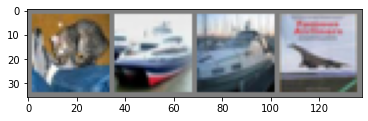

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [11]:
outputs = net(images.cuda())

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   car  ship plane


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [13]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 35 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다

In [14]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 56.7 %
Accuracy for class car   is: 54.1 %
Accuracy for class bird  is: 7.7 %
Accuracy for class cat   is: 0.2 %
Accuracy for class deer  is: 18.6 %
Accuracy for class dog   is: 53.5 %
Accuracy for class frog  is: 64.2 %
Accuracy for class horse is: 42.9 %
Accuracy for class ship  is: 27.5 %
Accuracy for class truck is: 31.5 %
